In [1]:
import glob
import librosa
import librosa.display
import matplotlib.pyplot
import numpy
import os
import scipy
import sklearn.cluster
import sklearn.mixture
from hmmlearn import hmm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

### Problem 1. Some clustering

In [2]:
class KMeans():
    def __init__(self, n_clusters: int, tol: float) -> None:
        self.n_clusters = n_clusters
        self.tol = tol
        self.cluster_centers_ = None
        self.labels_ = None

        return

    def fit(self, X: numpy.ndarray) -> tuple[numpy.ndarray, numpy.ndarray]:
        cluster_center_indices = numpy.random.choice(a=X.shape[0], size=self.n_clusters, replace=False)
        cluster_centers = X[cluster_center_indices]
    
        while True:
            dists = scipy.linalg.norm(a=(X[:, numpy.newaxis]-cluster_centers), axis=2)
            labels = numpy.argmin(a=dists, axis=1)

            new_cluster_centers = []
            for i in range(self.n_clusters):
                cluster_mu = X[labels==i].mean(axis=0)
                new_cluster_centers.append(cluster_mu)
            new_cluster_centers = numpy.vstack(tup=new_cluster_centers, dtype=numpy.float32)

            if numpy.all(scipy.linalg.norm(a=(new_cluster_centers-cluster_centers), axis=0) <= self.tol):
                break

            cluster_centers = new_cluster_centers

        self.cluster_centers_ = cluster_centers
        self.labels_ = labels

        return self

    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
        dists = scipy.linalg.norm(a=(X[:, numpy.newaxis]-self.cluster_centers_), axis=2)

        return numpy.argmin(a=dists, axis=1)

In [14]:
def time_to_frames(times: float, sr: int, hop_length: int, n_fft: int=None) -> int:
    return librosa.time_to_frames(times=times, sr=sr, hop_length=hop_length, n_fft=n_fft)

def create_labels(labels_filepath: str, sr: int, hop_length: int, n_fft: int=None) -> numpy.ndarray:
    dtypes = [("start_time", "float64"), ("end_time", "float64"), ("label", "U10")]
    label_data = numpy.genfromtxt(fname=labels_filepath, dtype=dtypes, delimiter='\t', skip_header=0, skip_footer=0)

    classes = numpy.array([label_info[2] for label_info in label_data])
    classes = numpy.unique(ar=classes)
    print(f"[INFO]: class info: {classes[0]}: 0, {classes[1]}: 1, {classes[2]}: 2")

    frame_labels = numpy.array(object=[], dtype=numpy.uint8)
    for label_info in label_data:
        start_time, end_time, label = label_info
        start_frame = time_to_frames(times=start_time, sr=sr, hop_length=hop_length, n_fft=N_FFT)
        end_frame = time_to_frames(times=end_time, sr=sr, hop_length=hop_length, n_fft=N_FFT)
        label_id = numpy.where(classes==label)[0]
        labels = numpy.full(shape=(end_frame-start_frame), fill_value=label_id, dtype=numpy.uint8)
        frame_labels = numpy.append(arr=frame_labels, values=labels)
    frame_labels = numpy.append(arr=frame_labels, values=label_id)
    
    return frame_labels

In [15]:
SAMPLING_RATE = 22050
N_FFT = 2048
HOP_LENGTH = N_FFT//4
WIN_LENGTH = N_FFT//2
N_MFCC = 100

dataset_dir = "friends"
audio_filepath = dataset_dir + "/friends.wav"
labels_filepath = dataset_dir + "/labels.txt"

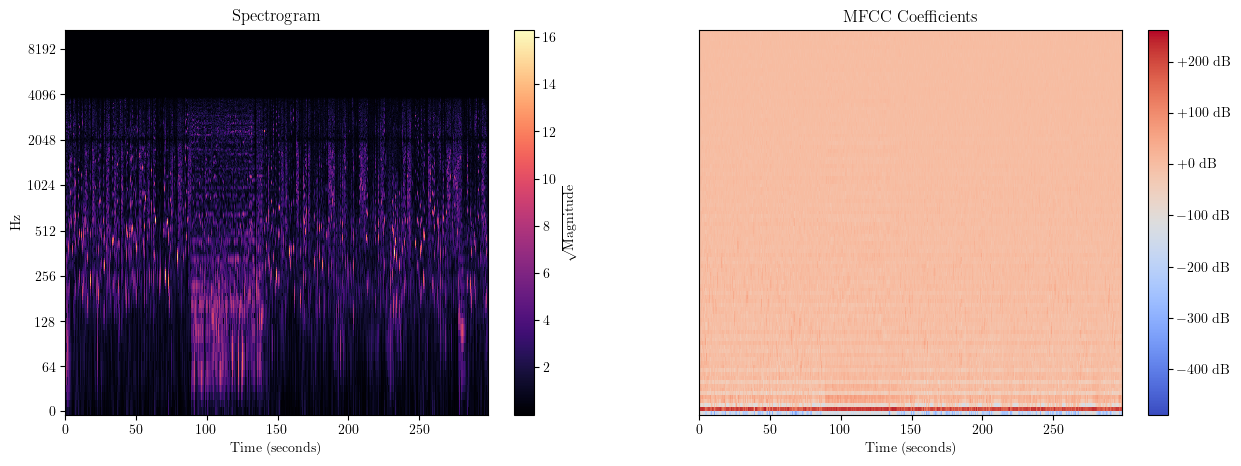

In [16]:
y, _ = librosa.load(path=audio_filepath, sr=SAMPLING_RATE, dtype=numpy.float64)
spec = librosa.stft(y=y, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
spec = numpy.abs(spec)
spec_sqrt = numpy.sqrt(spec)

m = librosa.feature.mfcc(y=y, sr=SAMPLING_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH,
                         win_length=WIN_LENGTH)

matplotlib.pyplot.rc('font', family='serif')
matplotlib.pyplot.rc(group="text", usetex=True)
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15, 5))
img_0 = librosa.display.specshow(data=spec_sqrt, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_fft=N_FFT,
                                 win_length=WIN_LENGTH, x_axis='s', y_axis="log", ax=ax[0])
fig.colorbar(mappable=img_0, ax=[ax[0]], label=r"$\sqrt{\textnormal{Magnitude}}$")
ax[0].set_title("Spectrogram")

img_1 = librosa.display.specshow(data=m, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_fft=N_FFT,
                                 win_length=WIN_LENGTH, x_axis='s', ax=ax[1])
fig.colorbar(mappable=img_1, ax=[ax[1]], format=r"$%+2.0f$ dB")
ax[1].set_title("MFCC Coefficients")

matplotlib.pyplot.show()

In [17]:
mu = numpy.mean(a=m, axis=1, keepdims=True, dtype=numpy.float64)
sig = numpy.std(a=m, axis=1, keepdims=True, dtype=numpy.float64)
m = (m-mu)/sig

In [36]:
frame_labels = create_labels(labels_filepath=labels_filepath, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_fft=N_FFT)
print(frame_labels.shape)

[INFO]: class info: laughter: 0, music: 1, speech: 2
(12865,)


The frame labels are created by first reading the `labels.txt` file. Firstly, the labels (*laughter*, *music*, *speech*) are encoded as integer shown above. Then, the frame numbers are generated by using `librosa.time_to_frames` to convert the time in `labels.txt` with the same *sampling rate*, *hop length*, and *fft window length* as the functions `librosa.load` and `librosa.stft` used into frame numbers. Among the range of the frame numbers that maps to the corresponding label's start time and end time, the same index is appended to `frame_labels` frame numbers time.

For the correction of cluster labels, three subsets of the audio data containing only the *laughter*, *music*, and *speech* are clipped separately and extracted features with `mfcc` function. Additionlly, these clips are run through the three algorithms *K-means*, *GMM clustering*, and *HMM* all with 1 component. Their corresponding *cluster centers*, *weights*, and *means* are carefully examined so that cluster ids can be correctly remapped with the correct ids.

In [37]:
N_COMPONENTS = 3
TOL = 1e-3
MAX_ITER = 1000
RANDOM_STATE = None
N_INIT = 100

#### K-means clustering

In [38]:
def kmeans_labels(cluster_centers: numpy.ndarray, labels: numpy.ndarray) -> numpy.ndarray:
    first_elements = cluster_centers[:, 0]
    indices = numpy.zeros(shape=3, dtype=numpy.uint8)
    indices[0] = numpy.where((first_elements >= 0.5) & (first_elements <= 0.6))[0]
    indices[1] = numpy.where((first_elements >= 0.65) & (first_elements <= 0.75))[0]
    indices[2] = numpy.where((first_elements >= -1.1) & (first_elements <= -0.9))[0]

    mask_0 = labels == 0
    mask_1 = labels == 1
    mask_2 = labels == 2

    labels[mask_0] = indices[0]
    labels[mask_1] = indices[1]
    labels[mask_2] = indices[2]

    return labels

In [39]:
kmeans = sklearn.cluster.KMeans(n_clusters=N_COMPONENTS, n_init=N_INIT, tol=TOL, max_iter=MAX_ITER,
                                random_state=RANDOM_STATE)
kmeans.fit(X=m.T)
cluster_centers = kmeans.cluster_centers_
labels = kmeans.predict(X=m.T)
labels = kmeans_labels(cluster_centers=cluster_centers, labels=labels)

report = classification_report(y_true=frame_labels, y_pred=labels, labels=None, target_names=None)
print(report)

              precision    recall  f1-score   support

           0       0.44      0.87      0.59      2773
           1       0.85      0.87      0.86      2485
           2       0.90      0.57      0.70      7607

    accuracy                           0.69     12865
   macro avg       0.73      0.77      0.72     12865
weighted avg       0.79      0.69      0.71     12865



#### GMM clustering

In [28]:
def gmm_labels(weights: numpy.ndarray, labels: numpy.ndarray) -> numpy.ndarray:
    indices = numpy.zeros(shape=3, dtype=numpy.uint8)
    indices[0] = numpy.where((weights >= 0.5) & (weights <= 0.7))[0]
    indices[1] = numpy.where((weights >= 0.2) & (weights <= 0.3))[0]
    indices[2] = numpy.where((weights >= 0.1) & (weights < 0.2))[0]

    mask_0 = labels == 0
    mask_1 = labels == 1
    mask_2 = labels == 2

    labels[mask_0] = indices[0]
    labels[mask_1] = indices[1]
    labels[mask_2] = indices[2]

    return labels

In [29]:
gmm = sklearn.mixture.GaussianMixture(n_components=N_COMPONENTS, covariance_type="full", tol=TOL, max_iter=MAX_ITER,
                                      random_state=RANDOM_STATE)
gmm.fit(X=m.T)
weights = gmm.weights_
labels = gmm.predict(X=m.T)
labels = gmm_labels(weights=weights, labels=labels)

report = classification_report(y_true=frame_labels, y_pred=labels, labels=None, target_names=None)
print(report)

              precision    recall  f1-score   support

           0       0.33      0.95      0.49      2773
           1       0.79      0.88      0.83      2485
           2       0.96      0.27      0.42      7607

    accuracy                           0.54     12865
   macro avg       0.70      0.70      0.58     12865
weighted avg       0.79      0.54      0.52     12865



#### 3-state HMM

In [30]:
def hmm_labels(means: numpy.ndarray, labels: numpy.ndarray) -> numpy.ndarray:
    first_elements = means[:, 0, 0]
    indices = numpy.zeros(shape=3, dtype=numpy.uint8)
    indices[0] = numpy.where((first_elements >= -0.3) & (first_elements <= -0.15))[0]
    indices[1] = numpy.where((first_elements >= 0.75) & (first_elements <= 0.85))[0]
    indices[2] = numpy.where((first_elements >= -0.1) & (first_elements < 0))[0]

    mask_0 = labels == 0
    mask_1 = labels == 1
    mask_2 = labels == 2

    labels[mask_0] = indices[0]
    labels[mask_1] = indices[1]
    labels[mask_2] = indices[2]

    return labels

In [31]:
hmm_model = hmm.GMMHMM(n_components=N_COMPONENTS, tol=TOL, n_iter=MAX_ITER, random_state=RANDOM_STATE)
hmm_model.fit(X=m.T)
means = hmm_model.means_
labels = hmm_model.predict(X=m.T)
labels = hmm_labels(means=means, labels=labels)

report = classification_report(y_true=frame_labels, y_pred=labels, labels=None, target_names=None)
print(report)

              precision    recall  f1-score   support

           0       0.39      0.95      0.55      2773
           1       0.97      0.89      0.93      2485
           2       0.95      0.48      0.64      7607

    accuracy                           0.66     12865
   macro avg       0.77      0.77      0.71     12865
weighted avg       0.84      0.66      0.68     12865



From the three experiments above, the 3-state HMM achieves the highest accuracy when segmenting the soundtrack into three sound classes, *laughter*, *music*, *speech*. One common drawback is that all three models are relatively bad at classifying laughter. This is probably because *laughter* is really close to *speech*, so they are misclassified with each other frequently. Additionally, music is the best classified sound class with the highest f1-score. This is probably because *music* is fairly different from *laughter* and *speech*.

### Problem 2. Recognition of temporal sequences

In [44]:
SAMPLING_RATE = 22050
N_FFT = 2048
HOP_LENGTH = N_FFT//4
WIN_LENGTH = N_FFT//2
N_MFCC = 20

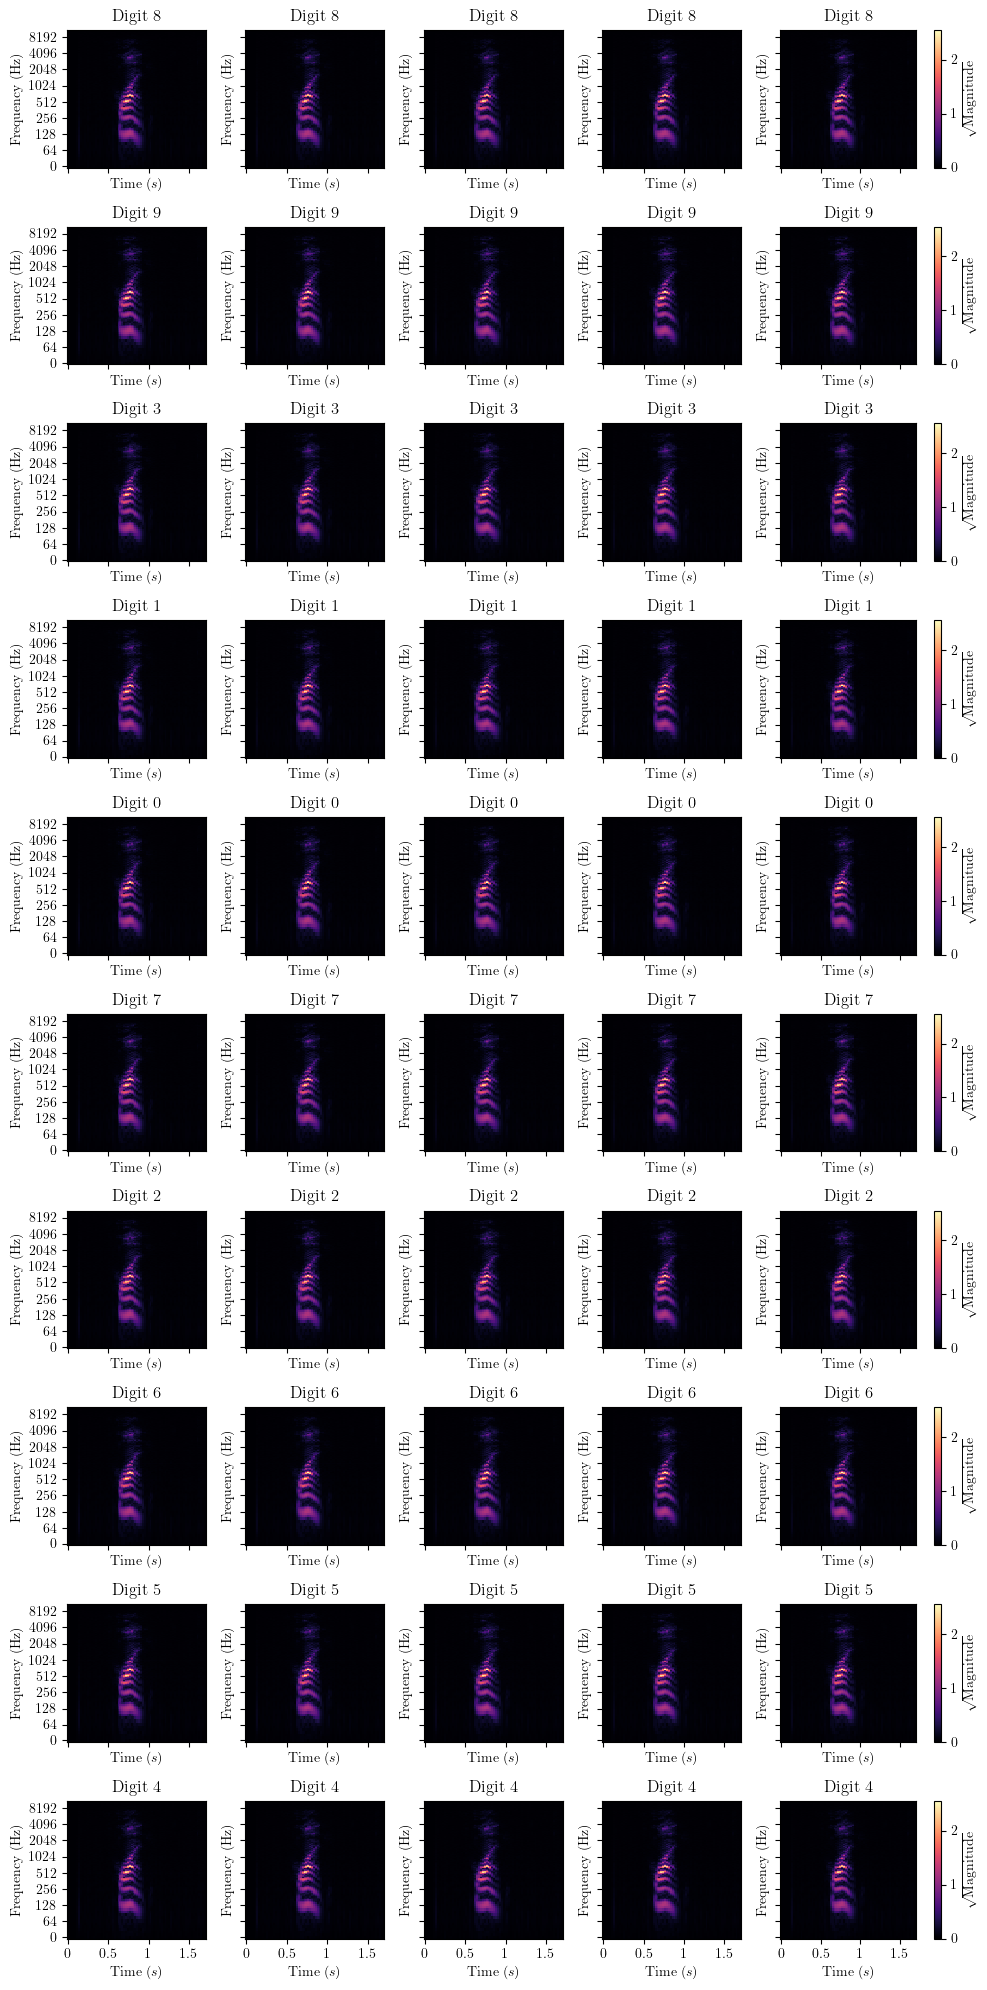

In [45]:
num_map = {"zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
           "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9}

dataset_dir = "digits"
digit_dirs = os.listdir(path=dataset_dir)

fig, axs = matplotlib.pyplot.subplots(10, 5, figsize=(10, 20), gridspec_kw={"width_ratios": [1, 1, 1, 1, 1.3]},
                                      sharex=True, sharey=True)
matplotlib.pyplot.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.50, hspace=0.50)

for i, digit_dir in enumerate(digit_dirs):
    for j in range(5):
        audio_filepath = f"digits/{digit_dir}/{digit_dir}_{j}.wav"
        y, _ = librosa.load(path="digits/one/one_0.wav", sr=SAMPLING_RATE, dtype=numpy.float64)
        spec = librosa.stft(y=y, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
        spec = numpy.abs(spec)
        spec_sqrt = numpy.sqrt(spec)
        img = librosa.display.specshow(data=spec_sqrt, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_fft=N_FFT,
                                       win_length=WIN_LENGTH, x_axis='s', y_axis="log", ax=axs[i, j])
        axs[i, j].set_title(f'Digit {num_map[digit_dir]}')
        axs[i, j].set_xlabel(r'Time $(s)$')
        axs[i, j].set_ylabel(r'Frequency (Hz)')

        if j == 4:
            axs[i, j].set_aspect('auto')
            cbar = fig.colorbar(img, ax=axs[i, j], pad=0.1)
            cbar.set_label(label=r"$\sqrt{\textnormal{Magnitude}}$")

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [46]:
class SpokenDigit():
    def __init__(self, dataset_dir: str, num_map: dict) -> None:
        self.classes = numpy.array(object=list(num_map.values()), dtype=numpy.uint8)
        self.data = []
        self.labels = []
        self.__load_data_labels(dataset_dir=dataset_dir, num_map=num_map)
        self.data_train_ = []
        self.labels_train_ = []
        self.data_test_ = []
        self.labels_test_ = []

        return

    def __load_data_labels(self, dataset_dir: str, num_map: dict) -> None:
        digit_dirs = list(num_map.keys())

        for i, digit_dir in enumerate(digit_dirs):
            filepath = os.path.join(dataset_dir, digit_dir, f"{digit_dir}_*.wav")
            filepaths = glob.glob(pathname=filepath)

            data = []
            for filepath in filepaths:
                y, sr = librosa.load(path=filepath)
                m = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH,
                                         win_length=WIN_LENGTH, dtype=numpy.float64)
                data.append(m.T)

            self.data.append(data)
            labels = numpy.full(shape=(len(filepaths)), fill_value=i, dtype=numpy.uint8)
            
            self.labels.append(labels)

        return

    def train_test_split(
            self,
            test_pct: float,
            train_pct: float,
            rand_state: int
    ) -> tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]:
        if rand_state is not None:
            numpy.random.seed(seed=rand_state)

        for data, label in zip(self.data, self.labels):
            test_size = int(len(data)*test_pct)
            indices = numpy.arange(len(data))
            numpy.random.shuffle(indices)
            indices_test = indices[:test_size]

            data_class_train = []
            labels_class_train = []
            for i, (d, l) in enumerate(zip(data, label)):
                if i not in indices_test:  
                    data_class_train.append(d)
                    labels_class_train.append(l)
                else:
                    self.data_test_.append(d)
                    self.labels_test_.append(l)

            self.data_train_.append(data_class_train)
            self.labels_train_.append(labels_class_train)

        self.labels_test_ = numpy.hstack(tup=self.labels_test_, dtype=numpy.uint8)

        return

In [84]:
class SpokenDigitRecog():
    def __init__(
            self,
            dataset_dir: str,
            num_map: dict,
            test_pct: float,
            train_pct: float,
            rand_state: int
    ) -> None:
        self.num_map = num_map
        self.spoken_digit = SpokenDigit(dataset_dir=dataset_dir, num_map=num_map)
        self.spoken_digit.train_test_split(test_pct=test_pct, train_pct=train_pct, rand_state=rand_state)
        self.models_ = {}

    def train_HMM(self) -> None:
        for i in range(len(self.spoken_digit.data_train_)):
            model = hmm.GMMHMM(n_components=10)
            data_train = self.spoken_digit.data_train_[i]
            data_train = numpy.vstack(tup=data_train, dtype=numpy.float64)
            model.fit(X=data_train)
            self.models_[i] = model

        return

    def test_HMM(self, test_set: str) -> None:
        if test_set == "train":
            data = [data for data_cls_test in self.spoken_digit.data_train_ for data in data_cls_test]
            labels = numpy.hstack(tup=self.spoken_digit.labels_train_, dtype=numpy.uint8)
        elif test_set == "test":
            data = self.spoken_digit.data_test_
            labels = self.spoken_digit.labels_test_
        else:
            print("[ERROR]: Invalid data type.")

        preds = numpy.array(object=[], dtype=numpy.uint8)

        for i in range(len(data)):
            scores = numpy.array(object=[], dtype=numpy.float64)
            for cls in list(self.models_.keys()):
                model = self.models_[cls]
                score = model.score(X=data[i])
                scores = numpy.append(arr=scores, values=score)
            pred = numpy.argmax(a=scores, axis=0)
            preds = numpy.append(arr=preds, values=pred)

        report = classification_report(y_true=labels, y_pred=preds,
                                       labels=list(self.num_map.values()),
                                       target_names=list(self.num_map.keys()))
        print(report)

        conf_mat = sklearn.metrics.confusion_matrix(y_true=labels, y_pred=preds,
                                                    labels=list(self.num_map.values()))

        print(f"[INFO]: Confusion Matrix {test_set}")
        print(conf_mat)

        return

In [87]:
sdr = SpokenDigitRecog(dataset_dir=dataset_dir, num_map=num_map,
                       test_pct=0.25, train_pct=0.75, rand_state=None)
sdr.train_HMM()
sdr.test_HMM(test_set="train")
print()
sdr.test_HMM(test_set="test")

              precision    recall  f1-score   support

        zero       1.00      1.00      1.00        15
         one       1.00      0.93      0.97        15
         two       0.79      1.00      0.88        15
       three       1.00      1.00      1.00        15
        four       1.00      0.93      0.97        15
        five       0.94      1.00      0.97        15
         six       1.00      1.00      1.00        15
       seven       1.00      1.00      1.00        15
       eight       1.00      0.87      0.93        15
        nine       1.00      0.93      0.97        15

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

[INFO]: Confusion Matrix train
[[15  0  0  0  0  0  0  0  0  0]
 [ 0 14  1  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0]
 [ 0  0  1  0 14  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0]
 [ 0  0  0  

### Problem 3. Activity recognition

Two implementations are shown for this problem.

The first implementation is a Vector Autoregressive Model `VAR` with `Linear Rregression` in it. The `Linear Regression` is used to learn the weight matrices `W` and bias `b` from the past `p` (lag order) time samples. Each class learned *the training set size of that class 50%* (half of the data from that class) number of `W` and `b`. Then, these `W` and `b` are averaged to produce the final `VAR` model for this class. Finally, the `W` and `b` are used to iteratively predict `steps` number of future steps, and then calculated the norm with respect to the ground truth from the test set. Among all the norms from 4 classes, the *argmin* is predicted as the result of activity.

The second implementation is also a Vector Autoregressive Model `VAR` with `Linear Rregression` in it. However, instead of averaging `W` and `b`, `Gradient Descent` is performed to make the `W` and `b` fits the training dataset of that class.

In [101]:
def create_class_map(class_filepath: str, class_names: list[str]) -> dict:
    dtypes = [("labels", "uint8"), ("activity", "U20")]
    class_info = numpy.genfromtxt(fname=class_filepath, dtype=dtypes, delimiter=' ', skip_header=0, skip_footer=0)
    class_map = dict(class_info)
    class_map = {k-1: v for k, v in class_map.items() if v in class_names}

    return class_map

In [102]:
class HAR():
    def __init__(self, dataset_dir: str, classes: numpy.ndarray) -> None:
        self.classes = classes
        self.data = None
        self.labels = None
        self.__load_data(dataset_dir=dataset_dir)
        self.__load_labels(dataset_dir=dataset_dir)
        self.__filter(classes=classes)
        self.data_train_ = []
        self.labels_train_ = []
        self.data_test_ = None
        self.labels_test_ = None
        self.data_train_test_ = None
        self.labels_train_test_ = None

        return

    def __load_data(self, dataset_dir: str) -> None:
        x_filepath = os.path.join(dataset_dir, "test", "Inertial_Signals", "total_acc_x_test.txt")
        y_filepath = os.path.join(dataset_dir, "test", "Inertial_Signals", "total_acc_y_test.txt")
        z_filepath = os.path.join(dataset_dir, "test", "Inertial_Signals", "total_acc_z_test.txt")
        x = numpy.loadtxt(fname=x_filepath, dtype=numpy.float64)
        y = numpy.loadtxt(fname=y_filepath, dtype=numpy.float64)
        z = numpy.loadtxt(fname=z_filepath, dtype=numpy.float64)
        self.data = numpy.stack(arrays=(x, y, z), axis=2)

        return

    def __load_labels(self, dataset_dir: str) -> None:
        label_filepath = os.path.join(dataset_dir, "test", "y_test.txt")
        self.labels = numpy.loadtxt(fname=label_filepath, dtype=numpy.uint8)
        self.labels -= 1

        return

    def __filter(self, classes: list[int]) -> None:
        mask = numpy.isin(element=self.labels, test_elements=classes)
        N = numpy.count_nonzero(a=mask)
        self.data = self.data[mask]
        self.labels = self.labels[mask]

        assert N == self.data.shape[0] == self.labels.shape[0]

    def train_test_split(
            self,
            test_pct: float,
            train_pct: float,
            rand_state: int
    ) -> tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]:
        if rand_state is not None:
            numpy.random.seed(seed=rand_state)

        mu = numpy.mean(a=self.data, axis=0, dtype=numpy.float64)
        sig = numpy.std(a=self.data, axis=0, dtype=numpy.float64)
        self.data = (self.data-mu)/sig

        data_test = []
        labels_test = []
        for cls in self.classes:
            indices_cls = numpy.where(self.labels==cls)[0]
            test_size = int(indices_cls.shape[0]*test_pct)
            indices_cls_test = numpy.random.choice(a=indices_cls, size=test_size, replace=False)
            mask = numpy.isin(element=indices_cls, test_elements=indices_cls_test, assume_unique=True)
            indices_cls_train = indices_cls[~mask]
            self.data_train_.append(self.data[indices_cls_train])
            self.labels_train_.append(self.labels[indices_cls_train])
            data_test.append(self.data[indices_cls_test])
            labels_test.append(self.labels[indices_cls_test])

        self.data_train_test_ = numpy.vstack(tup=self.data_train_, dtype=numpy.float64)
        self.labels_train_test_ = numpy.hstack(tup=self.labels_train_, dtype=numpy.uint8)
        assert self.data_train_test_.shape[0] == self.labels_train_test_.shape[0]

        self.data_test_ = numpy.vstack(tup=data_test, dtype=numpy.float64)
        self.labels_test_ = numpy.hstack(tup=labels_test, dtype=numpy.uint8)
        assert self.data_test_.shape[0] == self.labels_test_.shape[0]

        return

In [103]:
class VAR():
    def __init__(self, p: int) -> None:
        self.p = p
        self.model = sklearn.linear_model.LinearRegression()

        return

    def __train_x(self, X: numpy.ndarray, p: int, steps: int) -> numpy.ndarray:
        n = X.shape[0]

        data_train = []
        for i in range(steps):
            data_train.append(X[i:i+p].flatten(order='C'))

        X = numpy.vstack(tup=data_train, dtype=numpy.float64)

        return X

    def fit(self, X: numpy.ndarray, y: numpy.ndarray, p:int, steps: int) -> None:
        X = self.__train_x(X=X, p=p, steps=steps)
        self.model.fit(X=X, y=y)

        return

    def predict(self, X: numpy.ndarray, steps: int) -> None:
        return

In [104]:
class ActRecog():
    def __init__(self, dataset_dir: str, class_map: dict, lag_order: int) -> None:
        self.classes = numpy.unique(ar=list(class_map.keys()))
        self.class_names = list(class_map.values())
        self.lag_order = lag_order
        self.har = HAR(dataset_dir=dataset_dir, classes=self.classes)
        self.har.train_test_split(test_pct=0.5, train_pct=0.5, rand_state=None)
        self.VAR_models_ = {}

        return

    def __test_x(self, X: numpy.ndarray, p: int, steps: int) -> numpy.ndarray:
        n = X.shape[0]

        data_test = []
        for i in range(steps):
            data_test.append(X[i:i+p].flatten(order='C'))

        X = numpy.vstack(tup=data_test, dtype=numpy.float64)

        return X

    def train_VAR_models(self, p: int, steps: int) -> None:
        for cls in self.classes:
            W = []
            b = []

            for X, y in zip(self.har.data_train_[cls], self.har.labels_train_[cls]):
                y = X[p:p+steps]
                var = VAR(p=p)
                var.fit(X=X, y=y, p=p, steps=steps)
                W.append(var.model.coef_)
                b.append(var.model.intercept_)

            W = numpy.stack(arrays=W, axis=0, dtype=numpy.float64)
            W = numpy.mean(a=W, axis=0, dtype=numpy.float64)
            b = numpy.stack(arrays=b, axis=0, dtype=numpy.float64)
            b = numpy.mean(a=b, axis=0, dtype=numpy.float64)
            self.VAR_models_[cls] = [W, b]

    def test_VAR_models(self, p: int, steps: int, test_set: str) -> None:
        if test_set == "train":
            data = self.har.data_train_test_
            labels = self.har.labels_train_test_
        elif test_set == "test":
            data = self.har.data_test_
            labels = self.har.labels_test_
        else:
            print("[ERROR]: Invalid data type.")

        preds = numpy.array(object=[], dtype=numpy.uint8)
        for X, y in zip(data, labels):
            loss = numpy.array(object=[], dtype=numpy.float64)
            for cls in range(0, self.classes.size):
                forecasts = []
                W, b = self.VAR_models_[cls]
                x = X[:p].flatten(order='F')
                for step in range(steps):
                    forecast = x@W.T + b
                    forecasts.append(forecast)
                    x = numpy.hstack(tup=[x[3:], forecast], dtype=numpy.float64)

                forecasts = numpy.vstack(tup=forecasts, dtype=numpy.float64)
                y_true = X[self.lag_order:self.lag_order+steps]
                mse = scipy.linalg.norm(a=(forecasts-y_true))
                loss = numpy.append(arr=loss, values=mse)
            pred = numpy.argmin(a=loss, axis=0)
            preds = numpy.append(arr=preds, values=pred)
        # print(preds)
        # print(self.har.labels_test_)
        report = classification_report(y_true=labels, y_pred=preds, labels=self.classes,
                                       target_names=self.class_names)
        print(report)

        conf_mat = sklearn.metrics.confusion_matrix(y_true=labels, y_pred=preds,
                                                    labels=self.classes)
        print(conf_mat)

        return

In [105]:
P = 50      # lag order
STEPS = 50  # future steps

dataset_dir = "HAR"
class_filepath = dataset_dir + "/activity_labels.txt"
class_names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING"]
class_map = create_class_map(class_filepath=class_filepath, class_names=class_names)

In [106]:
actrecog = ActRecog(dataset_dir=dataset_dir, class_map=class_map, lag_order=P)
actrecog.train_VAR_models(p=P, steps=STEPS)
actrecog.test_VAR_models(p=P, steps=STEPS, test_set="train")
actrecog.test_VAR_models(p=P, steps=STEPS, test_set="test")

                    precision    recall  f1-score   support

           WALKING       0.38      0.22      0.28       248
  WALKING_UPSTAIRS       0.49      0.51      0.50       236
WALKING_DOWNSTAIRS       0.31      0.47      0.37       210
           SITTING       0.75      0.72      0.74       246

          accuracy                           0.48       940
         macro avg       0.48      0.48      0.47       940
      weighted avg       0.49      0.48      0.48       940

[[ 55  74  91  28]
 [ 45 120  64   7]
 [ 38  49  98  25]
 [  8   0  60 178]]
                    precision    recall  f1-score   support

           WALKING       0.39      0.22      0.28       248
  WALKING_UPSTAIRS       0.56      0.57      0.57       235
WALKING_DOWNSTAIRS       0.28      0.40      0.33       210
           SITTING       0.68      0.71      0.70       245

          accuracy                           0.48       938
         macro avg       0.48      0.48      0.47       938
      weighted avg

In [ ]:
class HAR():
    def __init__(self, dataset_dir: str, classes: numpy.ndarray) -> None:
        self.classes = classes
        self.data = None
        self.labels = None
        self.__load_data(dataset_dir=dataset_dir)
        self.__load_labels(dataset_dir=dataset_dir)
        self.__filter(classes=classes)
        self.data_train_ = []
        self.labels_train_ = []
        self.data_test_ = None
        self.labels_test_ = None
        self.data_train_test_ = None
        self.labels_train_test_ = None

        return

    def __load_data(self, dataset_dir: str) -> None:
        x_filepath = os.path.join(dataset_dir, "test", "Inertial_Signals", "total_acc_x_test.txt")
        y_filepath = os.path.join(dataset_dir, "test", "Inertial_Signals", "total_acc_y_test.txt")
        z_filepath = os.path.join(dataset_dir, "test", "Inertial_Signals", "total_acc_z_test.txt")
        x = numpy.loadtxt(fname=x_filepath, dtype=numpy.float64)
        y = numpy.loadtxt(fname=y_filepath, dtype=numpy.float64)
        z = numpy.loadtxt(fname=z_filepath, dtype=numpy.float64)
        self.data = numpy.stack(arrays=(x, y, z), axis=2)

        return

    def __load_labels(self, dataset_dir: str) -> None:
        label_filepath = os.path.join(dataset_dir, "test", "y_test.txt")
        self.labels = numpy.loadtxt(fname=label_filepath, dtype=numpy.uint8)
        self.labels -= 1

        return

    def __filter(self, classes: list[int]) -> None:
        mask = numpy.isin(element=self.labels, test_elements=classes)
        N = numpy.count_nonzero(a=mask)
        self.data = self.data[mask]
        self.labels = self.labels[mask]

        assert N == self.data.shape[0] == self.labels.shape[0]

    def train_test_split(
            self,
            test_pct: float,
            train_pct: float,
            rand_state: int
    ) -> tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]:
        if rand_state is not None:
            numpy.random.seed(seed=rand_state)

        mu = numpy.mean(a=self.data, axis=0, dtype=numpy.float64)
#         self.data -= mu
        sig = numpy.std(a=self.data, axis=0, dtype=numpy.float64)
        self.data = (self.data-mu)/sig

        data_test = []
        labels_test = []
        for cls in self.classes:
            # modify this line
            # indices_cls = numpy.where(self.labels==cls)[0]
            indices_cls = numpy.where(self.labels==cls)[0][:420]
            test_size = int(indices_cls.shape[0]*test_pct)
            indices_cls_test = numpy.random.choice(a=indices_cls, size=test_size, replace=False)
            mask = numpy.isin(element=indices_cls, test_elements=indices_cls_test, assume_unique=True)
            # modify this line
            # indices_cls_train = indices_cls[~mask]
            indices_cls_train = indices_cls[~mask][:indices_cls_test.shape[0]]
            self.data_train_.append(self.data[indices_cls_train])
            self.labels_train_.append(self.labels[indices_cls_train])
            data_test.append(self.data[indices_cls_test])
            labels_test.append(self.labels[indices_cls_test])

        self.data_train_ = numpy.stack(arrays=self.data_train_, axis=0, dtype=numpy.float64)
        self.labels_train_ = numpy.stack(arrays=self.labels_train_, axis=0, dtype=numpy.uint8)
        print(self.data_train_.shape)
        print(self.labels_train_.shape)
        assert self.data_train_.shape[0] == self.labels_train_.shape[0]

        self.data_train_test_ = numpy.vstack(tup=self.data_train_, dtype=numpy.float64)
        self.labels_train_test_ = numpy.hstack(tup=self.labels_train_, dtype=numpy.uint8)
        print(self.data_train_test_.shape)
        print(self.labels_train_test_.shape)
        assert self.data_train_test_.shape[0] == self.labels_train_test_.shape[0]

        self.data_test_ = numpy.vstack(tup=data_test, dtype=numpy.float64)
        self.labels_test_ = numpy.hstack(tup=labels_test, dtype=numpy.uint8)
        print(self.data_test_.shape)
        print(self.labels_test_.shape)
        assert self.data_test_.shape[0] == self.labels_test_.shape[0]
        return

#         for a,b in zip(data_train, labels_train):
#             print(len(a), len(b))
#         print("-------")
#         for a,b in zip(data_test, labels_test):
#             print(a.shape, b.shape)

        return

In [ ]:
class LinearRegression():
    def __init__(self, lr: float, tol: float) -> None:
        self.lr = lr
        self.tol = tol
        self.W_ = None
        self.b_ = None

        return

    def sigmoid(self, z: numpy.ndarray) -> None:
        return 1/(1+numpy.exp(-z))

    def fit(self, X_batch: numpy.ndarray, y_batch: numpy.ndarray) -> None:
        n = X_batch.shape[1]
        self.W_ = numpy.zeros(shape=(y_batch.shape[2], X_batch.shape[2]), dtype=numpy.float64)
        self.b_ = numpy.zeros(shape=y_batch.shape[2], dtype=numpy.float64)
        prev_loss = float('inf')

        i = 0
        while True and i <= 1000:
            for X, y in zip(X_batch, y_batch):
                y_p = X@self.W_.T+self.b_
                dW = 1/n*(y_p-y).T@X
                db = 1/n*numpy.sum(y_p-y, axis=0)
                self.W_ -= self.lr*dW
                self.b_ -= self.lr*db
            print(numpy.abs(numpy.sum(y_p-y)))
            if numpy.abs(numpy.sum(y_p-y)) <= self.tol:
                break
            i += 1

        return

    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
        z = X.T@self.W+self.b
        y_pred = self.sigmoid(z)

        return (y_pred >= 0.5).astype(int)

In [110]:
class VAR():
    def __init__(self, p: int, lr: float, tol: float) -> None:
        self.p = p
        self.model = LinearRegression(lr=lr, tol=tol)

        return

    def fit(self, X_batch: numpy.ndarray, y_batch: numpy.ndarray) -> None:
        self.model.fit(X_batch=X_batch, y_batch=y_batch)

        return

    def predict(self, X: numpy.ndarray, steps: int) -> None:
        return

In [111]:
class ActRecog():
    def __init__(self, dataset_dir: str, class_map: dict, lag_order: int) -> None:
        self.classes = numpy.unique(ar=list(class_map.keys()))
        self.class_names = list(class_map.values())
        self.lag_order = lag_order
        self.har = HAR(dataset_dir=dataset_dir, classes=self.classes)
        self.har.train_test_split(test_pct=0.5, train_pct=0.5, rand_state=None)
        self.VAR_models_ = {}

        return

    def __train_x(self, X: numpy.ndarray, p: int, steps: int) -> numpy.ndarray:
        n = X.shape[1]

        data = []
        for i in range(steps):
            data.append(X[:, i:i+p].reshape(X.shape[0], -1))

        X = numpy.stack(arrays=data, axis=0, dtype=numpy.float64).transpose((1, 0, 2))

        return X

    def __train_y(self, y: numpy.ndarray, p: int, steps: int) -> numpy.ndarray:
        y = y[:, p:p+steps]

        return y

    def train_VAR_models(self, p: int, steps: int, lr: float, tol: float) -> None:
        for cls in self.classes:
            print(f"[INFO]: Training model {cls}...")
            W = []
            b = []

            X = self.__train_x(X=self.har.data_train_[cls], p=p, steps=steps)
            y = self.__train_y(y=self.har.data_train_[cls], p=p, steps=steps)
            var = VAR(p=p, lr=lr, tol=tol)
            var.fit(X_batch=X, y_batch=y)
            self.VAR_models_[cls] = [var.model.W_, var.model.b_]

    def test_VAR_models(self, p: int, steps: int, data: str) -> None:
        if data == "train":
            data_test = self.har.data_train_test_
            labels_test = self.har.labels_train_test_
        elif data == "test":
            data_test = self.har.data_test_
            labels_test = self.har.labels_test_
        else:
            print("[ERROR]: Invalid data type.")

        preds = numpy.array(object=[], dtype=numpy.uint8)
        for X, y in zip(data_test, labels_test):
            loss = numpy.array(object=[], dtype=numpy.float64)
            for cls in range(0, self.classes.size):
                forecasts = []
                W, b = self.VAR_models_[cls]
                x = X[:p].flatten(order='F')

                for step in range(steps):
                    forecast = x@W.T + b
                    forecasts.append(forecast)
                    x = numpy.hstack(tup=[x[3:], forecast], dtype=numpy.float64)

                forecasts = numpy.vstack(tup=forecasts, dtype=numpy.float64)
                y_true = X[self.lag_order:self.lag_order+steps]
                mse = scipy.linalg.norm(a=(forecasts-y_true))
                loss = numpy.append(arr=loss, values=mse)
            pred = numpy.argmin(a=loss, axis=0)
            preds = numpy.append(arr=preds, values=pred)
        print(preds)
        print(self.har.labels_test_)
        report = classification_report(y_true=labels_test, y_pred=preds, labels=self.classes,
                                       target_names=self.class_names)
        print(report)

        conf_mat_test = sklearn.metrics.confusion_matrix(y_true=labels_test, y_pred=preds,
                                                         labels=self.classes)
        print(conf_mat_test)

        return

In [112]:
LAG_ORDER = 50
STEPS = 50

dataset_dir = "HAR"
class_filepath = dataset_dir + "/activity_labels.txt"
class_names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING"]
class_map = create_class_map(class_filepath=class_filepath, class_names=class_names)

In [119]:
actrecog = ActRecog(dataset_dir=dataset_dir, class_map=class_map, lag_order=LAG_ORDER)
actrecog.train_VAR_models(p=50, steps=50, lr=5e-3, tol=1e-1)

(4, 210, 128, 3)
(4, 210)
(840, 128, 3)
(840,)
(840, 128, 3)
(840,)
[INFO]: Training model 0...
5.076209957349138
4.294058200923484
4.036438779493635
3.8931583282395246
3.795116096761273
3.7204698058518946
3.6600444270139088
3.60939586621135
3.566071365774722
3.5285297384652012
3.4956918196293456
3.4667428608502933
3.4410388163737693
3.4180571294258266
3.397367674220373
3.378613588133966
3.3614974786826295
3.3457708914834074
3.3312259625785066
3.3176886496698437
3.3050131664783726
3.293077366473247
3.2817788931869587
3.2710319591312733
3.2607646455600796
3.250916636823738
3.241437318993752
3.2322841846540777
3.223421495389754
3.214819161277136
3.206451803068496
3.1982979680825925
3.1903394752878675
3.182560868848203
3.1749489626150282
3.1674924607810677
3.1601816422347033
3.1530080981272555
3.1459645138411028
3.1390444879653248
3.1322423820848395
3.125553196201294
3.118972465457129
3.1124961745497814
3.1061206868252884
3.099842685544037
3.0936591252332994
3.08756719139285
3.08156426711

2.4255241835197
2.425030500743199
2.424538319169704
2.424047629966558
2.4235584243754484
2.42307069371125
2.422584429361671
2.4220996227863125
2.421616265516212
2.4211343491528705
2.4206538653677594
2.4201748059016035
2.4196971625637165
2.419220927231215
2.418746091848603
2.418272648426899
2.417800589043074
2.417329905839539
2.4168605910232905
2.416392636865392
2.4159260357004486
2.4154607799258683
2.414996862001164
2.4145342744477483
2.4140730098478858
2.413613060844474
2.4131544201401187
2.4126970804968106
2.412241034735371
2.411786275734729
2.411332796431364
2.4108805898190444
2.4104296489478534
2.4099799669240465
2.409531536909192
2.409084352119925
2.408638405827139
2.4081936913557738
2.4077502020841366
2.4073079314432584
2.4068668729167033
2.4064270200398954
2.4059883663995527
2.4055509056334072
2.4051146314294414
2.404679537525814
2.404245617710033
2.4038128658185323
2.403381275736436
2.4029508413968257
2.402521556780494
2.4020934159154526
2.401666412876355
2.4012405417842695
2.4

2.285002811322265
2.28480642630642
2.2846103325190286
2.2844145292990765
2.284219015987784
2.2840237919285373
2.2838288564668714
2.2836342089505903
2.283439848729453
2.2832457751554838
2.283051987582826
2.282858485367683
2.282665267868459
2.2824723344455533
2.2822796844614057
2.282087317280663
2.2818952322699655
2.281703428798
2.2815119062354627
2.2813206639551176
2.2811297013317575
2.2809390177421656
2.280748612565117
2.2805584851813645
2.2803686349737116
2.280179061326797
2.2799897636273068
2.2798007412639274
2.2796119936271606
2.2794235201095647
2.279235320105472
2.279047393011261
2.2788597382251314
2.2786723551472634
2.2784852431795013
2.2782984017258867
2.278111830192038
2.277925527985586
2.2777394945159872
2.2775537291945365
2.2773682314342887
2.2771830006501093
2.2769980362588234
2.276813337678999
2.2766289043308636
2.2764447356365816
2.2762608310200294
2.2760771899068284
2.275893811724414
2.2757106959019673
2.2755278418704323
2.275345249062371
2.275162916912183
2.27498084485591

1.671626229251951
1.671070059199426
1.6705157745919734
1.6699633610008298
1.6694128041513039
1.6688640899206657
1.6683172043361785
1.667772133573185
1.6672288639531332
1.666687381941763
1.6661476741471648
1.6656097273179742
1.665073528341627
1.6645390642424671
1.6640063221800996
1.6634752894475677
1.662945953469849
1.6624183018019103
1.6618923221272544
1.6613680022562254
1.660845330124468
1.6603242937912777
1.6598048814381148
1.6592870813670264
1.6587708819991793
1.6582562718733653
1.6577432396445317
1.657231774082336
1.656721864069783
1.6562134986017627
1.6557066667836629
1.6552013578301008
1.6546975610635057
1.6541952659128145
1.653694461912242
1.6531951386998287
1.652697286016401
1.6522008937041632
1.6517059517055785
1.651212450062026
1.650720378912756
1.6502297284936374
1.6497404891359932
1.6492526512655297
1.6487662054011207
1.6482811421537318
1.64779745222534
1.6473151264078667
1.646834155582091
1.646354530716569
1.6458762428666582
1.6453992831734907
1.6449236428628968
1.64444931

1.5110811575023724
1.5108376523419
1.5105944130414983
1.5103514390220476
1.5101087297070797
1.5098662845226491
1.5096241028973678
1.5093821842623598
1.5091405280512884
1.508899133700353
1.508658000648134
1.5084171283357803
1.5081765162068326
1.5079361637073303
1.507696070285701
1.507456235392761
1.5072166584817468
1.50697733900829
1.5067382764303479
1.5064994702082382
1.5062609198045946
1.5060226246844413
1.5057845843150373
1.5055467981659676
1.5053092657090954
1.5050719864184998
1.5048349597705732
1.5045981852439054
1.5043616623193448
1.5041253904798866
1.5038893692108075
1.503653597999443
1.5034180763354381
1.5031828037105075
1.5029477796185193
1.5027130035554817
1.5024784750194824
1.5022441935107707
1.502010158531622
1.501776369586479
1.501542826181801
1.501309527826026
1.5010764740297438
1.5008436643055312
1.5006110981679763
1.5003787751336355
1.500146694721192
1.4999148564510787
1.4996832598459358
1.4994519044301784
1.499220789730276
1.4989899152745778
1.4987592805933503
1.4985288

0.5402483466552188
0.5396849169725915
0.5391234639031015
0.5385639660207391
0.5380064022543887
0.5374507518811533
0.5368969945196045
0.5363451101234509
0.535795078974989
0.5352468816789697
0.534700499156558
0.5341559126391942
0.5336131036628864
0.5330720540622995
0.5325327459653013
0.5319951617874068
0.5314592842262702
0.5309250962564875
0.5303925811244552
0.5298617223431943
0.5293325036874066
0.5288049091886267
0.5282789231303844
0.5277545300436164
0.5272317147019765
0.526710462117447
0.5261907575357574
0.5256725864322689
0.5251559345076413
0.5246407876836836
0.5241271320992487
0.5236149541063893
0.5231042402663251
0.5225949773456331
0.5220871523125832
0.52158075233331
0.5210757647683917
0.5205721771691361
0.5200699772742459
0.5195691530064246
0.5190696924689386
0.5185715839424685
0.5180748158818351
0.5175793769129333
0.5170852558296251
0.5165924415906737
0.516100923316926
0.5156106902881925
0.5151217319407551
0.5146340378641867
0.5141475977989074
0.5136624016334068
0.5131784394015848

0.3773917333585146
0.3771254082834017
0.37685938971829636
0.376593677071265
0.37632826975235223
0.3760631671736543
0.3757983687493349
0.37553387389547144
0.3752696820302015
0.3750057925736605
0.3747422049478619
0.3744789185769326
0.3742159328868062
0.3739532473054603
0.3736908612627743
0.3734287741904676
0.3731669855223607
0.37290549469395295
0.37264430114282776
0.37238340430828254
0.3721228036316071
0.3718624985559269
0.3716024885261311
0.37134277298907903
0.3710833513933398
0.37082422318941277
0.37056538782952675
0.3703068447677551
0.3700485934599218
0.36979063336373263
0.36953296393851875
0.3692755846454969
0.3690184949475641
0.3687616943094525
0.36850518219748407
0.36824895807988245
0.3679930214264333
0.36773737170875886
0.3674820084001156
0.36722693097545744
0.3669721389113816
0.366717631686281
0.3664634087801426
0.36620946967455503
0.36595581385284803
0.3657024407999414
0.36544935000239565
0.3651965409484459
0.3649440131278734
0.36469176603207654
0.36443979915410707
0.36418811198

1.0210829324027537
1.0200642336135155
1.0190449596329172
1.0180252132113123
1.0170050941714883
1.0159846994829391
1.0149641233342768
1.0139434572037902
1.012922789928219
1.0119022077698097
1.010881794481611
1.0098616313712183
1.0088417973628194
1.007822369057715
1.0068034207933128
1.0057850247006297
1.004767250760351
1.0037501668574682
1.0027338388345488
1.0017183305436954
1.0007037038971442
0.9996900189166608
0.9986773337816336
0.9976657048760161
0.9966551868340655
0.9956458325849399
0.9946376933961978
0.9936308189161842
0.9926252572153899
0.9916210548267556
0.9906182567849602
0.9896169066647851
0.9886170466184552
0.9876187174120991
0.9866219584612709
0.9856268078656237
0.9846333024426777
0.9836414777607869
0.9826513681712736
0.9816630068397513
0.9806764257767067
0.9796916558672759
0.9787087269003136
0.9777276675967687
0.9767485056372691
0.975771267689124
0.9747959794325918
0.9738226655865254
0.9728513499333817
0.9718820553435945
0.9709148037993764
0.9699496164178967
0.968986513473923

0.7364081343274407
0.7360470751353171
0.7356867478507229
0.7353271501763374
0.7349682798251221
0.7346101345202284
0.7342527119949505
0.733896009992683
0.7335400262668423
0.7331847585808248
0.7328302047079507
0.7324763624313765
0.732123229544091
0.7317708038488124
0.7314190831579567
0.7310680652935799
0.7307177480873221
0.7303681293803546
0.7300192070233108
0.7296709788762533
0.7293234428086155
0.7289765966991302
0.7286304384358118
0.7282849659158593
0.7279401770456487
0.7275960697406666
0.7272526419254198
0.7269098915334471
0.7265678165072356
0.726226414798154
0.7258856843664455
0.725545623181139
0.725206229220016
0.7248675004695677
0.7245294349249309
0.7241920305898513
0.7238552854766249
0.7235191976060781
0.7231837650074577
0.7228489857184551
0.7225148577851157
0.7221813792618098
0.7218485482111808
0.7215163627040886
0.7211848208195917
0.7208539206448592
0.7205236602751734
0.7201940378138395
0.7198650513721859
0.7195366990694688
0.7192089790328859
0.7188818893974908
0.718555428306144

In [101]:
actrecog.test_VAR_models(p=50, steps=50, data="train")
actrecog.test_VAR_models(p=50, steps=50, data="test")

[3 3 2 3 3 2 1 2 2 1 0 2 3 3 3 2 3 3 3 3 3 3 3 3 3 3 2 3 3 3 2 2 3 2 3 1 3
 2 1 1 0 3 1 2 2 2 1 3 2 1 2 1 1 2 1 1 1 1 1 2 3 1 3 2 1 1 3 3 2 3 3 2 3 2
 2 2 3 2 3 3 3 3 2 2 2 2 3 3 1 2 2 3 2 3 2 1 0 3 0 1 0 0 3 2 3 3 3 3 2 3 3
 2 2 3 2 2 3 3 3 3 2 2 3 2 3 1 3 3 2 2 3 2 1 3 2 3 2 3 3 3 2 3 3 2 3 3 1 1
 2 3 3 2 3 3 1 3 2 0 3 1 2 1 2 1 2 3 0 3 2 1 3 2 0 2 3 1 0 1 2 1 2 0 2 3 2
 3 2 1 3 2 2 2 3 3 2 3 2 3 2 3 3 2 3 2 3 2 3 2 2 3 3 2 2 3 1 0 2 2 3 2 0 0
 3 3 3 3 2 2 3 3 3 1 1 3 1 2 1 2 2 1 2 2 3 1 0 2 2 1 3 3 1 3 2 3 1 3 2 3 3
 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 2 3 3 0 3 2 1 2 3 3 3 2 2 3
 2 3 3 2 2 3 3 3 3 3 3 3 3 3 2 3 3 2 2 2 2 2 3 3 3 3 3 2 2 3 3 3 3 2 1 3 3
 3 1 3 3 1 2 1 1 2 2 1 2 2 3 3 2 1 2 2 2 2 3 1 3 2 3 3 2 3 2 2 3 1 2 2 3 1
 3 3 3 0 1 3 3 3 3 0 3 3 3 2 2 2 2 2 3 0 3 3 3 3 2 1 3 3 3 1 1 1 3 3 3 3 3
 3 3 1 3 3 1 1 3 3 2 3 2 1 3 3 3 2 3 1 1 3 1 3 1 3 2 3 2 2 3 2 2 2 3 2 2 2
 2 2 2 1 1 2 3 1 1 1 2 3 3 3 3 2 2 1 2 3 0 1 2 2 1 0 0 2 1 0 2 0 0 3 0 3 3
 2 3 2 3 1 0 3 1 3 1 3 1 